In [1]:
import pandas as pd
import gensim
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb
import plotly.plotly as py
import plotly
import cufflinks as cf
import pprint
import json
import yaml

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords




paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress


In [2]:
CONFIG_FILE = '../../../../../APIKeys/API.yaml'

with open(CONFIG_FILE, 'r') as config_file:
    config = yaml.load(config_file)

PLOTLY_USERNAME = config["plotly"]["PLOTLY_USERNAME"]
PLOTLY_API_KEY = config["plotly"]["PLOTLY_API_KEY"]

plotly.tools.set_credentials_file(username = PLOTLY_USERNAME, api_key = PLOTLY_API_KEY)



In [3]:
main_data = pd.read_csv('../resources/news/cnn.csv')
main_data.head()


,Published On,Headline
0,"April 12, 2019",Following a military coup in the African count...
1,"April 11, 2019",Today's show explores sky and sea. We're showi...
2,"April 10, 2019",Could the deadline for Brexit be extended for ...
3,"April 9, 2019",First up this Tuesday on CNN 10: There's been ...
4,"April 8, 2019","Russia is racing to dominate the Arctic, and w..."


In [4]:
# Grab all the titles 
article_titles = main_data['Headline']
# Create a list of strings, one for each title
titles_list = [title for title in article_titles]

# Collapse the list of strings into a single long string for processing
big_title_string = ' '.join(titles_list)


# Tokenize the string into words
tokens = word_tokenize(big_title_string)

# Remove non-alphabetic tokens, such as punctuation
words = [word.lower() for word in tokens if word.isalpha()]

# Filter out stopwords
stop_words = set(stopwords.words('english'))

words = [word for word in words if not word in stop_words]

# Print first 10 words
words[:10]


['following',
 'military',
 'coup',
 'african',
 'country',
 'sudan',
 'examining',
 'turbulent',
 'tenure',
 'former']

In [29]:
main_data["Headline"][0]

"Following a military coup in the African country of Sudan, we're examining the turbulent tenure of former President Omar al-Bashir. After that, we're making a stop in India, a nation that has begun an election process that lasts more than a month. And we're showing you how an e-commerce company is utilizing drones to make deliveries in Australia."

In [5]:
# Load word2vec model (trained on an enormous Google corpus)
model = gensim.models.KeyedVectors.\
load_word2vec_format('../resources/model/GoogleNews-vectors-negative300.bin', binary = True) 

# Check dimension of word vectors
model.vector_size


300

In [6]:
# Filter the list of vectors to include only those that Word2Vec has a vector for
vector_list = [model[word] for word in words if word in model.vocab]

# Create a list of the words corresponding to these vectors
words_filtered = [word for word in words if word in model.vocab]

# Zip the words together with their vector representations
word_vec_zip = zip(words_filtered, vector_list)

# Cast to a dict so we can turn it into a dataframe
word_vec_dict = dict(word_vec_zip)
df = pd.DataFrame.from_dict(word_vec_dict, orient='index')
df.shape


(4714, 300)

In [7]:
df.head(10)

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
following,-0.006989,-0.011780,0.193359,-0.170898,0.049805,-0.049561,-0.192383,-0.085938,0.151367,0.126953,...,-0.137695,-0.052002,0.004578,0.056396,0.156250,-0.241211,0.013367,0.017944,0.053223,-0.015564
military,-0.034424,0.216797,-0.094727,0.165039,-0.127930,-0.110840,-0.078125,-0.134766,0.108398,0.055908,...,-0.216797,-0.111328,-0.174805,0.080566,-0.016846,-0.065918,-0.119141,-0.040039,0.155273,0.100098
coup,0.105469,0.015869,-0.131836,-0.198242,-0.112793,-0.363281,-0.339844,-0.324219,0.345703,0.058838,...,-0.519531,-0.058838,-0.531250,0.039551,-0.121094,0.021606,-0.232422,-0.181641,-0.171875,0.200195
african,-0.106934,0.253906,0.279297,0.425781,-0.121582,0.110352,-0.015991,-0.244141,-0.394531,-0.120117,...,-0.099121,0.096680,0.045654,0.150391,-0.051758,0.228516,0.142578,-0.021729,-0.158203,-0.055176
country,-0.080078,0.133789,0.143555,0.094727,-0.047363,-0.023560,-0.008545,-0.186523,0.045898,-0.081543,...,-0.145508,0.067383,-0.244141,-0.077148,0.047607,-0.075195,-0.149414,-0.044189,0.097168,0.067383
sudan,-0.028198,0.119629,0.092773,0.157227,0.068848,0.139648,-0.169922,-0.417969,-0.363281,0.081543,...,-0.060303,0.220703,0.106934,0.150391,-0.004181,0.071289,-0.333984,0.144531,-0.042969,0.129883
examining,-0.248047,0.159180,0.005890,-0.105469,0.132812,-0.014832,0.052002,-0.100586,0.306641,-0.183594,...,-0.176758,-0.324219,0.137695,0.202148,-0.147461,-0.193359,0.212891,-0.054443,-0.078613,0.096680
turbulent,0.094238,0.218750,-0.271484,-0.085449,0.198242,-0.170898,-0.240234,-0.263672,0.239258,0.092285,...,-0.102051,0.012451,0.026367,-0.044922,-0.279297,-0.010742,0.044678,0.222656,0.085449,0.071777
tenure,-0.119629,0.163086,-0.058105,-0.149414,0.166016,-0.355469,0.267578,-0.273438,0.118164,0.150391,...,-0.205078,-0.023560,-0.312500,-0.093750,-0.030151,-0.184570,-0.032227,0.006042,-0.201172,-0.062256
former,-0.020630,0.167969,0.187500,-0.204102,0.028687,0.048584,-0.109863,0.023804,0.074219,-0.023315,...,0.005524,0.030151,-0.069336,-0.137695,0.064941,-0.292969,0.110352,-0.093750,-0.065918,0.131836


In [35]:
from sklearn.manifold import TSNE

# Initialize t-SNE
tsne = TSNE(n_components = 2, init = 'random', random_state = 10, perplexity = 100)

# Use only 400 rows to shorten processing time
tsne_df = tsne.fit_transform(df[:400])


/anaconda3/lib/python3.6/site-packages/sklearn/neighbors/base.py:371: RuntimeWarning:

invalid value encountered in sqrt



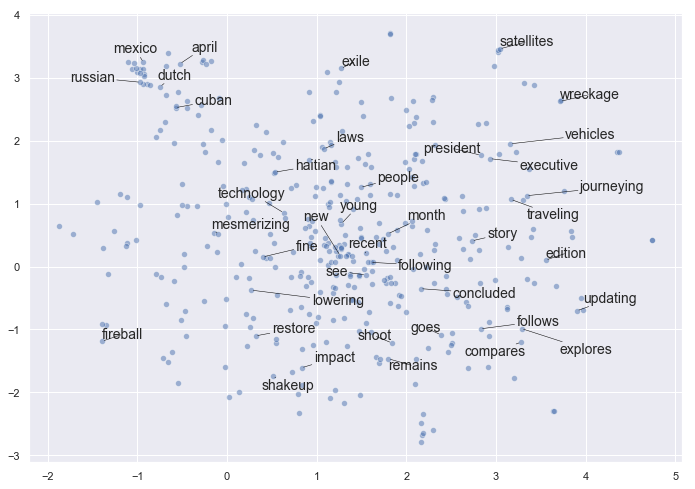

In [36]:
sns.set()

fig, ax = plt.subplots(figsize = (11.7, 8.27))
sns.scatterplot(tsne_df[:, 0], tsne_df[:, 1], alpha = 0.5)

# Second plot: Import adjustText, initialize list of texts
from adjustText import adjust_text
texts = []
words_to_plot = list(np.arange(0, 400, 10))

# Append words to list
for word in words_to_plot:
    texts.append(plt.text(tsne_df[word, 0], tsne_df[word, 1], df.index[word], fontsize = 14))
    
# Plot text using adjust_text (because overlapping text is hard to read)
adjust_text(texts, force_points = 0.4, force_text = 0.4, 
            expand_points = (2,1), expand_text = (1,2),
            arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5))

plt.show()


In [10]:
fig = {
    'data': [
  		{
  			'x': tsne_df[:, 0], 
        	'y': tsne_df[:, 1], 
        	'text': df.index,
            "mode": "markers"
        }]}   

py.plot(fig)


'https://plot.ly/~nichelle/9'

In [11]:
def document_vector(word2vec_model, doc):
    # remove out-of-vocabulary words
    doc = [word for word in doc if word in model.vocab]
    return np.mean(model[doc], axis=0)

# Our earlier preprocessing was done when we were dealing only with word vectors
# Here, we need each document to remain a document 
def preprocess(text):
    text = text.lower()
    doc = word_tokenize(text)
    doc = [word for word in doc if word not in stop_words]
    doc = [word for word in doc if word.isalpha()] 
    return doc

# Function that will help us drop documents that have no word vectors in word2vec
def has_vector_representation(word2vec_model, doc):
    """check if at least one word of the document is in the
    word2vec dictionary"""
    return not all(word not in word2vec_model.vocab for word in doc)

# Filter out documents
def filter_docs(corpus, texts, condition_on_doc):
    """
    Filter corpus and texts given the function condition_on_doc which takes a doc. The document doc is kept if condition_on_doc(doc) is true.
    """
    number_of_docs = len(corpus)

    if texts is not None:
        texts = [text for (text, doc) in zip(texts, corpus)
                 if condition_on_doc(doc)]

    corpus = [doc for doc in corpus if condition_on_doc(doc)]

    print("{} docs removed".format(number_of_docs - len(corpus)))

    return (corpus, texts)


In [12]:
# Preprocess the corpus
corpus = [preprocess(title) for title in titles_list]

# Remove docs that don't include any words in W2V's vocab
corpus, titles_list = filter_docs(corpus, titles_list, lambda doc: has_vector_representation(model, doc))

# Filter out any empty docs
corpus, titles_list = filter_docs(corpus, titles_list, lambda doc: (len(doc) != 0))
x = []
for doc in corpus: # append the vector for each document
    x.append(document_vector(model, doc))
    
X = np.array(x) # list to array


0 docs removed
0 docs removed


/anaconda3/lib/python3.6/site-packages/sklearn/neighbors/base.py:371: RuntimeWarning:

invalid value encountered in sqrt



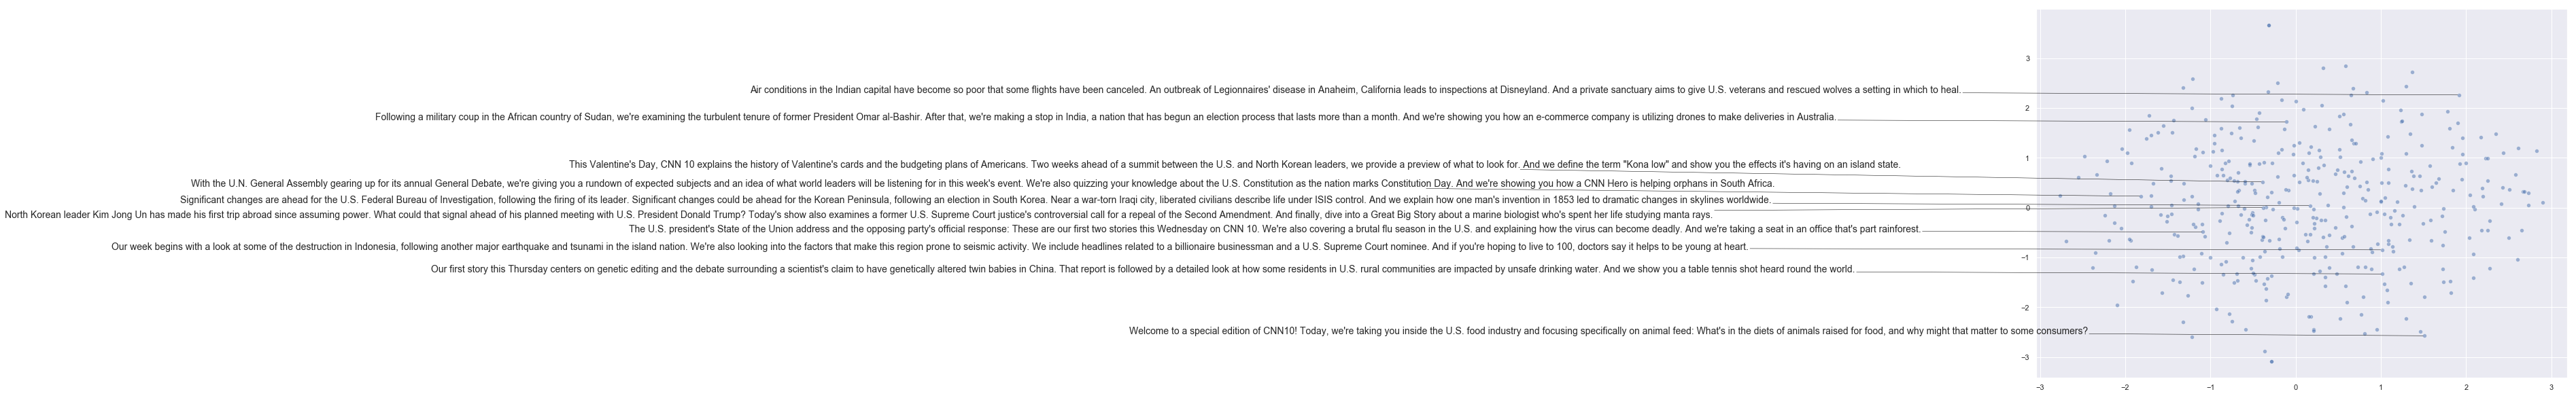

In [52]:
# Initialize t-SNE
tsne = TSNE(n_components = 2, init = 'random', random_state = 10, perplexity = 100)

# Again use only 400 rows to shorten processing time
tsne_df = tsne.fit_transform(X[:400])
fig, ax = plt.subplots(figsize = (14, 10))
sns.scatterplot(tsne_df[:, 0], tsne_df[:, 1], alpha = 0.5)

texts = []
titles_to_plot = list(np.arange(0, 400, 40)) # plots every 40th title in first 400 titles

# Append words to list
for title in titles_to_plot:
    texts.append(plt.text(tsne_df[title, 0], tsne_df[title, 1], titles_list[title], fontsize = 14))
    
# Plot text using adjust_text
adjust_text(texts, force_points = 0.4, force_text = 0.4, 
            expand_points = (2,1), expand_text = (1,2),
            arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5))

plt.show()


In [51]:
print(titles_to_plot)
type(texts[0])

[0, 100, 200, 300]


matplotlib.text.Text

In [53]:
fig2 = {
    'data': [
  		{
  			'x': tsne_df[:, 0], 
        	'y': tsne_df[:, 1], 
        	'text': titles_list[title],
            "mode": "markers"
        }]}   

py.plot(fig2)

'https://plot.ly/~nichelle/13'